In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import numpy as np
import os
import sys
from subprocess import call
import warnings
import argparse
import seaborn as sns
from dsa_analysis import load_config
import torch
import multiprocessing
from src.toolkit import pipeline
from src.dsa_optimization import dsa_computation
import pandas as pd
import matplotlib.pyplot as plt
import ipdb
import matplotlib.colors as mcolors

%load_ext autoreload
%autoreload 2

## Taking order into account

In [2]:
path = "../data/dsa_results"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        if file.endswith("ordered.csv"):
            # split the name of the file to get the parameters
            parameters = file.split("_")
            n_delay = int(parameters[1])
            delay_interval = int(parameters[2].split(".")[0])
            df = pd.read_csv(os.path.join(path, file))
            df["n_delay"] = n_delay
            df["delay_interval"] = delay_interval
            data.append(df)
data = pd.concat(data)
data.rename(columns={"number of shared elements":"number_of_shared_elements"}, inplace=True)
data_all = data.dropna()# plot on a single plot the Median similarity vs Number of shared elements for pair  (n_delay, delay_interval)
data = data_all.groupby(['n_delay', 'delay_interval','number_of_shared_elements'])["similarity"].mean().reset_index()
groups = data.groupby(['n_delay', 'delay_interval'])

### Plot curve

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

# Assuming 'data' and 'groups' are already defined as per your script

# Convert pandas DataFrame to Bokeh's ColumnDataSource
source = ColumnDataSource(data)

# Output the plot directly in the notebook
output_notebook()

# Create a figure
p = figure(width=800, height=600, title="Influence of n_delay on Median similarity vs Number of shared elements",
           x_axis_label='Number of shared elements', y_axis_label='Median similarity')

# Generate a consistent color scale for n_delay and delay_interval pairs
base_colors_n_delay = list(mcolors.TABLEAU_COLORS.values())
color_map_n_delay = {}

# Plotting
for i, (n_delay, delay_interval) in enumerate(data[['n_delay', 'delay_interval']].drop_duplicates().values):
    color = mcolors.rgb2hex(base_colors_n_delay[i % len(base_colors_n_delay)])
    color_map_n_delay[(n_delay, delay_interval)] = color

for (n_delay, delay_interval), group in groups:
    color = color_map_n_delay[(n_delay, delay_interval)]
    p.line(x='number_of_shared_elements', y='similarity', source=group,
           line_width=2, line_color=color, alpha=0.8,
           legend_label=f'n_delay={n_delay}, delay_interval={delay_interval}')

# Adding hover tool
hover = HoverTool()
hover.tooltips = [("Parameters", "@n_delay, @delay_interval")]
p.add_tools(hover)

# Remove the legend
p.legend.visible = False

# Show plot inline in notebook
show(p)




Loading BokehJS ...

### Select the 3 best ones

In [4]:
selected = [(15,13),(40,5),(50,4)]
data_selected = data_all[data_all[['n_delay', 'delay_interval']].apply(tuple, axis=1).isin(selected)]

In [5]:
grouped_data = data_selected.groupby(['n_delay', 'delay_interval', 'number_of_shared_elements']).agg(
    mean_similarity=('similarity', 'mean'),
    std_similarity=('similarity', 'std')
).reset_index()
grouped_data


,n_delay,delay_interval,number_of_shared_elements,mean_similarity,std_similarity
0,15,13,0,0.867324,0.509352
1,15,13,1,0.691545,0.520716
2,15,13,2,0.465267,0.469487
3,15,13,3,0.000000,0.000000
4,40,5,0,0.568301,0.326068
5,40,5,1,0.541875,0.314676
6,40,5,2,0.510124,0.303335
7,40,5,3,0.000000,0.000000
8,50,4,0,0.576922,0.330758
9,50,4,1,0.509537,0.315819


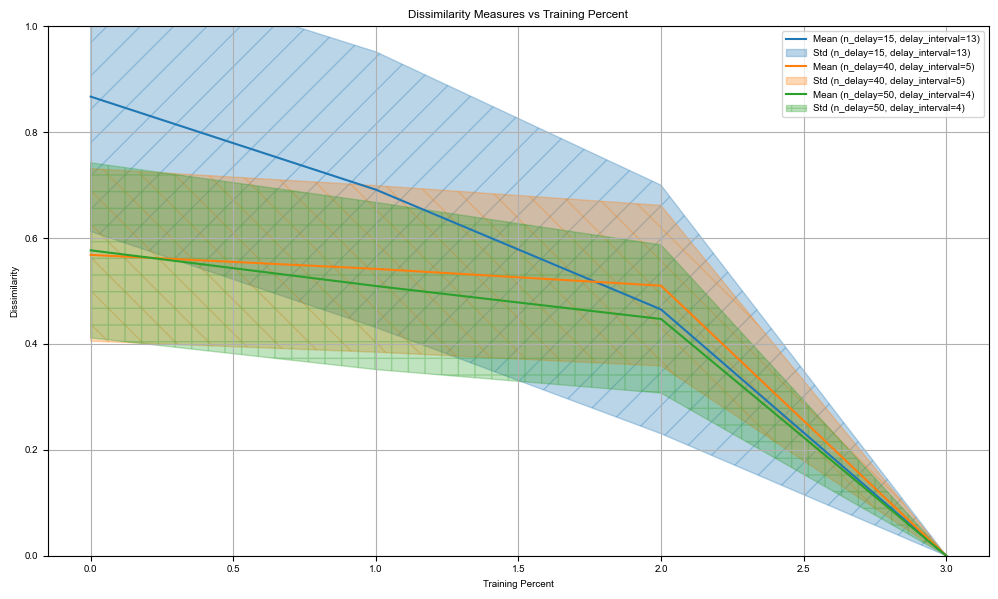

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

hatching_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

# Get unique (n_delay, delay_interval) pairs
unique_pairs = grouped_data[['n_delay', 'delay_interval']].drop_duplicates()
number_shared_elements = grouped_data['number_of_shared_elements'].unique()

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each unique pair with different hatching patterns
for i, (n_delay, delay_interval) in enumerate(unique_pairs.values):
    median = grouped_data["mean_similarity"][(grouped_data["n_delay"] == n_delay) & (grouped_data["delay_interval"] == delay_interval)]
    std = grouped_data["std_similarity"][(grouped_data["n_delay"] == n_delay) & (grouped_data["delay_interval"] == delay_interval)]
    color = f"C{i}"  # Cycle through different colors
    hatch = "/" if i == 0 else "\\" if i == 1 else "+"  # Different hatching patterns
    
    plt.plot(number_shared_elements, median, color=color, label=f"Mean (n_delay={n_delay}, delay_interval={delay_interval})")
    plt.fill_between(number_shared_elements, median - 0.5*std, median + 0.5*std, color=color, alpha=0.3, hatch=hatch, label=f"Std (n_delay={n_delay}, delay_interval={delay_interval})")

plt.title('Dissimilarity Measures vs Training Percent')
plt.xlabel('Training Percent')
plt.ylabel('Dissimilarity')
plt.ylim(0, 1) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Without order

In [7]:
path = "../data/dsa_results"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        if not file.endswith("ordered.csv"):
            # split the name of the file to get the parameters
            parameters = file.split("_")
            n_delay = int(parameters[1])
            delay_interval = int(parameters[2].split(".")[0])
            df = pd.read_csv(os.path.join(path, file))
            df["n_delay"] = n_delay
            df["delay_interval"] = delay_interval
            data.append(df)
data = pd.concat(data)
data.rename(
    columns={"number of shared elements": "number_of_shared_elements"}, inplace=True
)
data_all = (
    data.dropna()
)  # plot on a single plot the Median similarity vs Number of shared elements for pair  (n_delay, delay_interval)
data = (
    data_all.groupby(["n_delay", "delay_interval", "number_of_shared_elements"])[
        "similarity"
    ]
    .mean()
    .reset_index()
)
groups = data.groupby(["n_delay", "delay_interval"])

In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

# Assuming 'data' and 'groups' are already defined as per your script

# Convert pandas DataFrame to Bokeh's ColumnDataSource
source = ColumnDataSource(data)

# Output the plot directly in the notebook
output_notebook()

# Create a figure
p = figure(
    width=800,
    height=600,
    title="Influence of n_delay on Median similarity vs Number of shared elements",
    x_axis_label="Number of shared elements",
    y_axis_label="Median similarity",
)

# Generate a consistent color scale for n_delay and delay_interval pairs
base_colors_n_delay = list(mcolors.TABLEAU_COLORS.values())
color_map_n_delay = {}

# Plotting
for i, (n_delay, delay_interval) in enumerate(
    data[["n_delay", "delay_interval"]].drop_duplicates().values
):
    color = mcolors.rgb2hex(base_colors_n_delay[i % len(base_colors_n_delay)])
    color_map_n_delay[(n_delay, delay_interval)] = color

for (n_delay, delay_interval), group in groups:
    color = color_map_n_delay[(n_delay, delay_interval)]
    p.line(
        x="number_of_shared_elements",
        y="similarity",
        source=group,
        line_width=2,
        line_color=color,
        alpha=0.8,
        legend_label=f"n_delay={n_delay}, delay_interval={delay_interval}",
    )

# Adding hover tool
hover = HoverTool()
hover.tooltips = [("Parameters", "@n_delay, @delay_interval")]
p.add_tools(hover)

# Remove the legend
p.legend.visible = False

# Show plot inline in notebook
show(p)

Loading BokehJS ...

In [9]:
selected = [(33, 6), (66, 3), (50,4)]
data_selected = data_all[
    data_all[["n_delay", "delay_interval"]].apply(tuple, axis=1).isin(selected)
]

In [10]:
grouped_data = (
    data_selected.groupby(["n_delay", "delay_interval", "number_of_shared_elements"])
    .agg(mean_similarity=("similarity", "mean"), std_similarity=("similarity", "std"))
    .reset_index()
)
grouped_data

,n_delay,delay_interval,number_of_shared_elements,mean_similarity,std_similarity
0,33,6,1,0.764701,0.361694
1,33,6,2,0.628051,0.353630
2,33,6,3,0.360683,0.348122
3,50,4,1,0.605350,0.330334
4,50,4,2,0.519450,0.317660
5,50,4,3,0.322665,0.325451
6,66,3,1,0.719583,0.319694
7,66,3,2,0.612449,0.324076
8,66,3,3,0.387389,0.357763


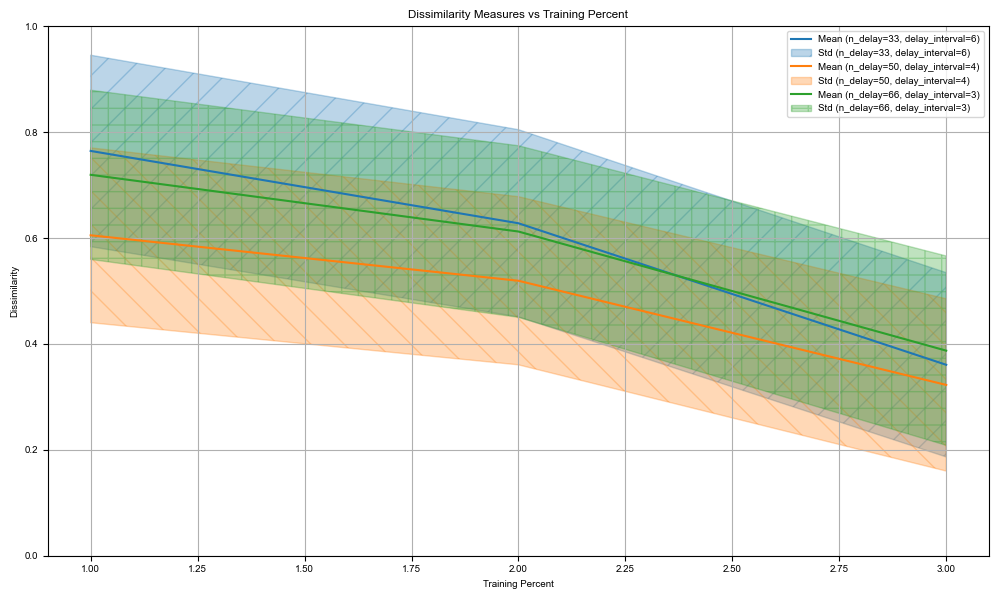

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

hatching_patterns = ["/", "\\", "|", "-", "+", "x", "o", "O", ".", "*"]

# Get unique (n_delay, delay_interval) pairs
unique_pairs = grouped_data[["n_delay", "delay_interval"]].drop_duplicates()
number_shared_elements = grouped_data["number_of_shared_elements"].unique()

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each unique pair with different hatching patterns
for i, (n_delay, delay_interval) in enumerate(unique_pairs.values):
    median = grouped_data["mean_similarity"][
        (grouped_data["n_delay"] == n_delay)
        & (grouped_data["delay_interval"] == delay_interval)
    ]
    std = grouped_data["std_similarity"][
        (grouped_data["n_delay"] == n_delay)
        & (grouped_data["delay_interval"] == delay_interval)
    ]
    color = f"C{i}"  # Cycle through different colors
    hatch = "/" if i == 0 else "\\" if i == 1 else "+"  # Different hatching patterns

    plt.plot(
        number_shared_elements,
        median,
        color=color,
        label=f"Mean (n_delay={n_delay}, delay_interval={delay_interval})",
    )
    plt.fill_between(
        number_shared_elements,
        median - 0.5 * std,
        median + 0.5 * std,
        color=color,
        alpha=0.3,
        hatch=hatch,
        label=f"Std (n_delay={n_delay}, delay_interval={delay_interval})",
    )

plt.title("Dissimilarity Measures vs Training Percent")
plt.xlabel("Training Percent")
plt.ylabel("Dissimilarity")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()